# Demonstration of preprocessing data and training GANs in REKINDLE

In this notebook we show you how to preprecess the training data (kinetic parameter sets generated by ORACLE) and then train the GANs for efficient generation. For this demonstration we provide a toy dataset consisting of 1000 kinetic parameter sets, stored in the folder /models/toy_data/toy_data.h5, the respective eigenvalues and a pickle file containing the names of the kinetic parameters. We dont expect that the learning will be complete with the toy dataset. The complete dataset (consisting of 80000 kinetic parameter sets for each physiology presented in the manuscript) can be found here - https://zenodo.org/record/5803120 (specifically in the models.zip / subfolder 4),

In [1]:

## Imports
import os, sys
import time
import yaml
import h5py
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cGANtools.GAN import CGAN
import helper as hp


2022-01-14 11:27:11.387416: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Num GPUs Available:  1


2022-01-14 11:27:12.247892: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-01-14 11:27:12.298566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-01-14 11:27:12.299382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVS 510 computeCapability: 3.0
coreClock: 0.797GHz coreCount: 1 deviceMemorySize: 1.94GiB deviceMemoryBandwidth: 26.55GiB/s
2022-01-14 11:27:12.299429: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-01-14 11:27:12.302710: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-01-14 11:27

## Preprocessing data

In [4]:
start = time.time()
print('\nSTARTING PREPROCESSING')

# pre-processing parameters

number_of_models = 1000  # No of kinetic models
parameter_set_dim = 411  # No of kinetic parameters in model

# fetch training set parameters
path_parameters = 'models/toy_data/toy_data.h5'

# fetch training set eigenvalues
path_stability = 'models/toy_data/toy_data.csv'
if not path_stability.endswith('.csv'):
    raise ValueError('Your data must be a .csv file')

# fetch parameter names
with open('models/toy_data/parameter_names.pkl', 'rb') as f:
    parameter_names = pickle.load(f)


# get the data and processed
f = h5py.File(path_parameters, 'r')
stabilities = pd.read_csv(path_stability).iloc[:, 1].values


all_data = np.empty([number_of_models, parameter_set_dim])
all_stabilities = np.empty([number_of_models])

J_partition = -9  #<--- Create class partition based on this eigenvalue
count0, count1 = 0, 0

for i in range(0, number_of_models):

    if i % 100 == 0:
        print(f'current set processed: {i}')
    this_param_set = f'parameter_set_{i}'
    param_values = np.array(f.get(this_param_set))

    mreal = stabilities[i]

    if mreal >= J_partition:
        stability = 1
        count0 += 1
    elif mreal < J_partition:
        stability = -1
        count1 += 1

    all_data[i] = param_values
    all_stabilities[i] = stability

all_data = np.array(all_data)
all_stabilities = np.array(all_stabilities)

n_param = all_data.shape[0]
print(f'% relevant models: {count1 / n_param}')

# keep only km

idx_to_keep = [i for i, x in enumerate(parameter_names) if 'km_' in x]
all_km = all_data[:, idx_to_keep]
all_km_names = [x for i, x in enumerate(parameter_names) if 'km_' in x]

print(f'Shape of all data: {all_km.shape}')

# take the log
log_all_data = np.log(all_km)  #Log transform all parameters

# train-val split
ratio = float(0.9)  # Partition of training and test data
n_data = log_all_data.shape[0]
limit = int(ratio * n_data)
all_idx = np.arange(n_data)
np.random.shuffle(all_idx)

idx_tr = all_idx[:limit]
idx_val = all_idx[limit:]

tr_data = log_all_data[idx_tr]
val_data = log_all_data[idx_val]

tr_stabi = all_stabilities[idx_tr]
val_stabi = all_stabilities[idx_val]

print(f'N data for training: {tr_data.shape[0]}')
print(f'N data for validation: {val_data.shape[0]}')

# save everything
exp_id = 'toy'
savepath = f'gan_input/{exp_id}'
os.makedirs(savepath, exist_ok=True)
np.save(f'{savepath}/all_km_{exp_id}.npy', all_km)
np.save(f'{savepath}/all_targets_{exp_id}.npy', all_stabilities)
np.save(f'{savepath}/X_train_{exp_id}.npy', tr_data)
np.save(f'{savepath}/X_val_{exp_id}.npy', val_data)

np.save(f'{savepath}/y_train_{exp_id}.npy', tr_stabi)
np.save(f'{savepath}/y_val_{exp_id}.npy', val_stabi)

with open(f'{savepath}/parameter_names_{exp_id}.pkl', 'wb') as f:
    pickle.dump(parameter_names, f)
with open(f'{savepath}/parameter_names_km_{exp_id}.pkl', 'wb') as f:
    pickle.dump(all_km_names, f)

end = time.time()
print(f'PROCESSING DONE in {end - start:.05} seconds')



STARTING PREPROCESSING
current set processed: 0
current set processed: 100
current set processed: 200
current set processed: 300
current set processed: 400
current set processed: 500
current set processed: 600
current set processed: 700
current set processed: 800
current set processed: 900
% relevant models: 0.592
Shape of all data: (1000, 259)
N data for training: 900
N data for validation: 100
PROCESSING DONE in 0.35093 seconds


## Training CGANs

In [5]:
# Training hyperparameters

latent_dim = 127      # Length of noise vector
epochs = 100           # Total number of epochs
n_sample = 100        # No of parameter sets to generate at every sampling epoch
repeats = 1           # number of training repeats
batchsize = 50      # Batchsize
sample_interval = 10  # Frequency of testing generator

exp_id = 'toy'       #<-- Choose 1 of 4 physiologies (fdp1-fdp4) or 'toy'
path_generator = None #<---if doing transfer learning put path to trained generator here else leave None
                      #    if loading model using load_model gives an error upgrade tensorflow to v2.3.0
                      #    > pip install tensorflow==2.3.0

print('\nSTARTING CGAN TRAINING')

# load the data for appropriate experiment
datapath = f'gan_input/{exp_id}/'
X_train = np.load(f'{datapath}X_train_{exp_id}.npy')
y_train = np.load(f'{datapath}y_train_{exp_id}.npy')

# Specify output folders
savepath = f'gan_output/{exp_id}/'

for j in range(0, repeats):

    print(f'Current exp: {exp_id}: Samples used: {np.shape(X_train)[0]}, repeat {j}')
    # set save directory
    this_savepath = f'{savepath}repeat_{j}/'
    os.makedirs(this_savepath, exist_ok=True)

    cgan = CGAN(X_train, y_train, latent_dim, batchsize, path_generator, savepath= this_savepath)
    d_loss, g_loss, acc = cgan.train(epochs, sample_interval, n_sample)

    # store training summary

    this_train_savepath = f'{this_savepath}training_summary/'
    os.makedirs(this_train_savepath, exist_ok=True)

    with open(f'{this_train_savepath}d_loss.pkl', 'wb') as f:
        pickle.dump(d_loss, f)
    with open(f'{this_train_savepath}g_loss.pkl', 'wb') as f:
        pickle.dump(g_loss, f)
    with open(f'{this_train_savepath}acc.pkl', 'wb') as f:
        pickle.dump(acc, f)


STARTING CGAN TRAINING
Current exp: toy: Samples used: 900, repeat 0


2022-01-14 11:28:00.232103: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-14 11:28:00.271263: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 3192640000 Hz
2022-01-14 11:28:00.274235: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5590bc1784c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-14 11:28:00.274279: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-14 11:28:00.589659: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5590ba6ad2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-01-14 11:28:00.589722: 

Total trainable parameters: 334692


2022-01-14 11:28:02.009241: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Epoch 0, D loss: 0.6680999994277954, acc: 58.44444458683332, G loss: 0.6135852299630642
Epoch 1, D loss: 0.5297656249668863, acc: 80.44444455040826, G loss: 0.6314952522516251
Epoch 2, D loss: 0.4029655046761036, acc: 88.88888872332043, G loss: 0.6580478503472276
Epoch 3, D loss: 0.3133301366534498, acc: 92.66666637526617, G loss: 0.7262146477070119
Epoch 4, D loss: 0.27752805646095013, acc: 91.55555483367708, G loss: 0.7953054544826349
Epoch 5, D loss: 0.29514602281981045, acc: 89.99999927149878, G loss: 0.9115757820092969
Epoch 6, D loss: 0.32498183308376205, acc: 88.88888822661505, G loss: 1.0046025295224454
Epoch 7, D loss: 0.2844160869717598, acc: 90.44444411993027, G loss: 1.069764282140467
Epoch 8, D loss: 0.36174745816323495, acc: 85.55555542310078, G loss: 1.1798230161269505
Epoch 9, D loss: 0.3905377553568946, acc: 84.66666605737474, G loss: 1.3340007718652487
Epoch 10, D loss: 0.43081072717905045, acc: 81.22222208314471, G loss: 1.3755008487237825
Epoch 11, D loss: 0.4252737

Epoch 93, D loss: 0.62414410793119, acc: 66.33333381679323, G loss: 1.3839861885127094
Epoch 94, D loss: 0.6104234829545021, acc: 66.11111197206709, G loss: 1.3688187829943166
Epoch 95, D loss: 0.6264127939939499, acc: 65.66666687528293, G loss: 1.3986541946522064
Epoch 96, D loss: 0.6038651441534361, acc: 67.77777762876616, G loss: 1.3796353907220893
Epoch 97, D loss: 0.6316086997588476, acc: 64.77777800626225, G loss: 1.345143545212017
Epoch 98, D loss: 0.6111910856432385, acc: 68.88888917035527, G loss: 1.3390318936564856
Epoch 99, D loss: 0.6347028911113739, acc: 63.666666381888916, G loss: 1.3437590810159843


## Plot criterion losses

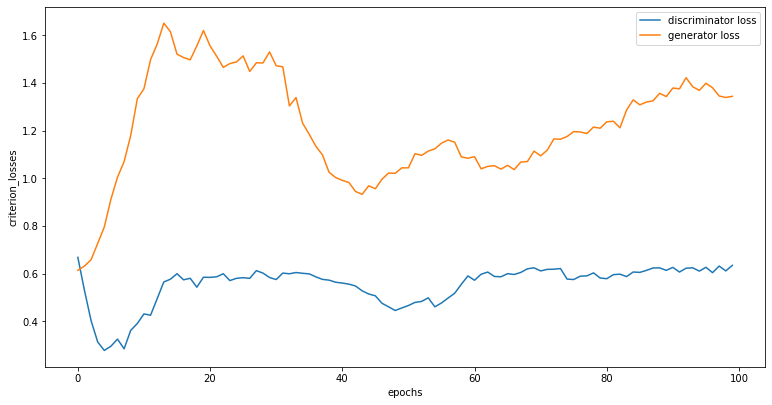

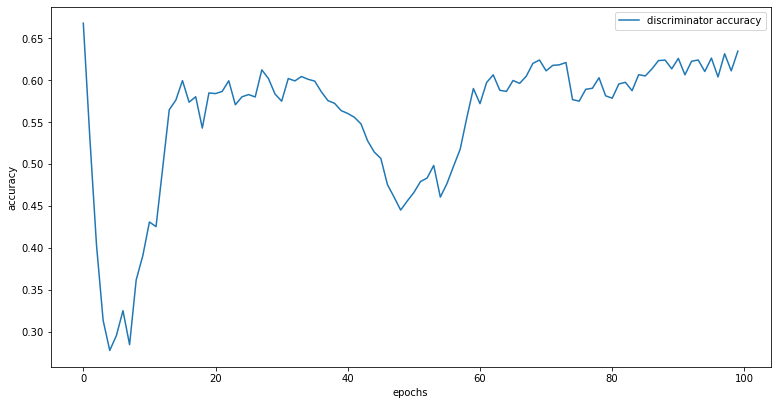

In [6]:
# plot metrics
x_plot = np.arange(0, epochs, 1)

fig = plt.figure(figsize = (10,5))
ax1 = fig.add_axes([0.2, 0.2, 1, 1])

ax1.plot(x_plot, d_loss, label = 'discriminator loss')
ax1.plot(x_plot, g_loss, label= 'generator loss')
ax1.set( ylabel = 'criterion_losses', xlabel = 'epochs')
ax1.legend()
plt.savefig(f'{this_train_savepath}loss.svg', dpi=300,
            transparent=False, bbox_inches='tight')

fig = plt.figure(figsize= (10,5))
ax2 = fig.add_axes([0.2, 0.2, 1, 1])

ax2.plot(x_plot, d_loss, label='discriminator accuracy')
ax2.set(ylabel='accuracy', xlabel='epochs')
ax2.legend()
plt.savefig(f'{this_train_savepath}d_accuracy.svg', dpi=300,
            transparent=False, bbox_inches='tight')

## Plot KL divergence

In [7]:
#Fetch relevant training data

training_data = np.load('gan_input/toy/X_train_toy.npy')
training_labels = np.load('gan_input/toy/y_train_toy.npy')

relevant_idx = np.where(training_labels==-1)[0]
relevant_training_data = training_data[relevant_idx,:]

training_mean = np.mean(relevant_training_data, axis = 0)

KL = []


#calculate KL divergence
for j in range(0, epochs, sample_interval):
    
    this_generated_set = np.load(f'gan_output/toy/repeat_0/{j}_r.npy')
    this_set_mean = np.mean(this_generated_set, axis = 0)
                                 
    p, q = hp.get_distributions([training_mean, this_set_mean])
    KL.append(hp.KL_div(p,q))                             

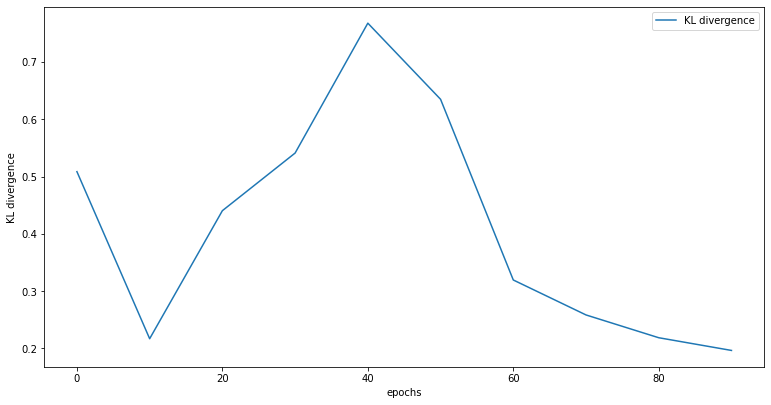

In [8]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_axes([0.2, 0.2, 1, 1])

x_plot = np.arange(0, epochs, sample_interval)
ax1.plot(x_plot, KL, label = 'KL divergence')
ax1.set( ylabel = 'KL divergence', xlabel = 'epochs')
ax1.legend()
plt.savefig(f'{this_train_savepath}KL_divergence.svg', dpi=300,
            transparent=False, bbox_inches='tight')